The code and write up below correspond to questions 1 and 2 of the computational assignment. The code is set up such that all functions are defined at the beginning, and ran later in the problem.
Notice that I do not use the transition matrix T for problem 1. After implementing it for problem 2 I aimed at rewritting the code for problem 1 to use the (time saving) approach of T, but I ran out of time.
After understanding the Transition matrix approach through spending a positive number of hours debugging the transition matrix function, I recognize it is indeed a very convenient way to set the problem up, which I didn't know about.


$v1$ refers to question 1, $v2$ refers to question 2.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
import time
from scipy import sparse
import numpy.linalg as lin

In [2]:
# Define primitives
def u_f1(S,y):
    '''Utility function version 1'''
    U = 2*y**0.5
    if y > S:
        U = -100000000
    return U

def u_f2(S,y):
    '''Utility function version 2'''
    U = 5*y - 0.05*y**2
    if y > S:
        U = -100000000
    return U

def Bellman_simple(Vp, ik, jk, utilitymatrix):
    '''
    Bellman Function for the non-interpolation case (Problem 1)
    '''
    Value = utilitymatrix[ik, jk] + δ * Vp[ik-jk]
    return(Value)

def Bellman_interp(Vp, ik, jk, utilitymatrix, T):
    ''' 
    Bellman : value function for state variable Kgrid[ik] with policy Kgrid[jk] (Problem 2)
    ''' 
    N = len(T)
    beg = N*jk
    fin = N*(jk+1)
    subT = T[ik, beg:fin] # get the index of the new state by subsetting in the transition matrix
    state_new = np.where(subT > 0)[0]
    if len(state_new)==1: # Reach the boundary: extraction > stock --> next stock == 0
        state_new1 = state_new[0]
        weight1 = subT[state_new1]
        Vnext = Vp[state_new1]*weight1
    if len(state_new)>1:
        state_new1 = state_new[0]
        state_new2 = state_new[1]
        weight1 = subT[state_new1]
        weight2 = subT[state_new2]
        Vnext = Vp[state_new1]*weight1 + Vp[state_new2]*weight2
    Value = utilitymatrix[ik, jk]  + δ * Vnext
    return (Value)

# Price functions = derivatives of utility functions wrt extraction (MU)
def p1_f(C1):
    return (1/(C1**0.5))

def p2_f(C2):
    return (5 - 0.1*C2)

In [3]:
def T_f(S, A, interp=True):
    '''
    This function computes the transition matrix for the interpolation problem (Problem 2)
    It can be easily adapted to the standard case
    '''
    
    # Initialize
    N = len(S)
    Na = len(A)
    T = np.zeros((N, N*Na))

    # For each action indexed k, and each initial state i, compute resulting state j
    if interp==True:
        for i in range(N):
            for k in range(Na):
                diff = S[i] - A[k]
                if diff < 0:
                    index1_raw = 0
                    index1_adj = index1_raw + (N)*k
                    T[i, index1_adj] = 1.0
                if diff >= 0:
                    dist = abs(S - diff) # How far from the difference is each element of S
                    index1_raw = np.where(dist == sorted(dist)[0])[0][0] # Find the index of the closest
                    index2_raw = np.where(dist == sorted(dist)[1])[0][0] # Find the index of the second closest
                    weight1 = 1 - sorted(dist)[0] / np.sum(sorted(dist)[0:2])
                    weight2 = 1 - sorted(dist)[1] / np.sum(sorted(dist)[0:2])
                    index1_adj = index1_raw + (N)*k
                    index2_adj = index2_raw + (N)*k
                    T[i, index1_adj] = weight1
                    T[i, index2_adj] = weight2
    return(T)

In [4]:
def VFI_v1(State_grid, Action_grid, V0, utilitymatrix, maxiter = 1000, tol=1e-8, δ=(1/1.05), howard=True, print_i=True):
    '''
    VFI routine for problem 1 
    (should be merged with VFI_v2 for concision but I'm running out of time)
    '''
    N = len(State_grid)
    Na = len(Action_grid)
    ### Initiate vectors & numbers
    iter = 0
    epsi = 1
    IndexAction_new = np.zeros(Na)
    Action = np.zeros(Na)
    Vp = V0
    Vp_new = np.zeros(N)

    while (epsi > tol) & (iter < maxiter):
        for ik in range(N):
            # ik = index of the stock today
            # d = max extraction < current stock
            #d = int(gk[max(ik-1), 0])
            d = 0

            #Value function Tj for each choice g(k)
            Vnext = np.zeros(len(State_grid)-d)

            # Compute the value function Tj for each choice of g(k)
            for jk in range(d, Na):
                    Vnext[jk - d] = Bellman_simple(Vp, ik, jk, utilitymatrix)

            # Choose the maximum
            Vp_new[ik] = np.max(Vnext)
            #IndexAction_new[ik] = d + int(np.where(Vnext==np.max(Vnext))[0][0])
            IndexAction_new[ik] = d + int(np.max(np.where(Vnext==np.max(Vnext))[0]))
        
        
        if howard==True:
            # Reduces the number of iterations by updating the Vnew grid more often
            for c in range(100):
                for ik in range(len(Action_grid)):
                    jk = int(IndexAction_new[ik])
                    Vp_new[ik] = Bellman_simple(Vp_new, ik, jk, utilitymatrix)

        
        ### Check the error
        epsi = np.abs(Vp_new - Vp).max()

        ### Keep track of what is going on
        if print_i==True:
            print("iteration is ", iter, " and Error term is ", epsi)
            
        IndexAction = IndexAction_new*1. #Update
        Vp = Vp_new*1. #Update
        
        if epsi < tol:
            break

        iter=iter+1

    #Calculate Values for g(k)
    for jk in range(len(Action_grid)):
        Action[jk] = Action_grid[int(IndexAction[jk])]
    print("Total number of iterations : ", iter)
        
    # Calculate the N*N optimal transition matrix T_opt that gives the state transition proba under optimal action
    return[Vp, IndexAction, Action, iter]
    

In [5]:
def VFI_v2(State_grid, Action_grid, V0, utilitymatrix, T, maxiter = 1000, tol = 1e-8, δ=(1/1.05), print_i=True):
    '''
    VFI Routine for Problem 2
    '''
    
    ### Initiate vectors & numbers
    iter = 0
    epsi = 1
    N = len(State_grid)
    Na = len(Action_grid)
    IndexAction_new = np.zeros(Na)
    Vp = np.zeros(N)

    while (epsi > tol) & (iter < maxiter):
        # Copy the old value vector
        Vold = np.copy(Vp)
        # Initiate the matrix 
        Vnextall = np.zeros((N, Na))
        # For each Na*N block (each action): computes the pair [old, new] states
        for jk in range(Na):
            beg = N*jk
            fin = N*(jk+1)
            Tnext = T[:,beg:fin]
            vals = T[:,beg:fin].dot(Vp)
            Vnextall[:,jk] = vals
        # V = U + δ V
        Uall = utilitymatrix + δ * Vnextall
        # Find the maximum total V for each starting i (Vp[i]), and the index of the corresponding action maxArgAction[i]
        maxArgAction = np.zeros(N)
        for i in range(N):
            maxArgAction[i] = np.argmax(Uall[i,:])
            Vp[i] = np.max(Uall[i,:])

        ### Check the error
        epsi = lin.norm(Vp - Vold)

        ### Keep track of what is going on
        if print_i==True:
            print("iteration is ", iter, " and Error term is ", epsi)

        IndexAction_new = np.copy(maxArgAction)

        if epsi < tol:
            break

        iter=iter+1
    
    return(Vp, IndexAction_new, iter)


## Question 1: Solving the DDP by value function iteration ; discrete state space

In [6]:
### Parameters
r = 0.05
δ = 1/(1+r)
Stot = 1000

N = 501
Na = 501
S1 = np.linspace(0,1000,N)
A1 = np.linspace(0,1000,Na)
V0 = np.zeros(N)

### Compute utility matrix for utility 1 and 2 
utilitymatrix1_v1 = np.ones((N, Na))
for i in range(0,N):
    for j in range(0,Na):
        utilitymatrix1_v1[i,j] = u_f1(S1[i], A1[j])
        
utilitymatrix2_v1 = np.ones((N, Na))
for i in range(0,N):
    for j in range(0,Na):
        utilitymatrix2_v1[i,j] = u_f2(S1[i], A1[j])
             

In [7]:
##### UTILITY 1
### Solve the model 
[Vp1_v1, IndexAction1_v1, Action1_v1, iter1_v1] = VFI_v1(S1, A1, V0, utilitymatrix1_v1, howard=True, print_i=False)
print("solving model 1 done")

### Calculate the N*N optimal transition matrix
T_opt1 = np.zeros((N, N))
for ik in range(N):
    ij = np.where(S1 == S1[ik] - Action1_v1[ik])[0][0]
    T_opt1[ik, ij] = 1  
    
##### UTILITY 2
### Solve the model 
[Vp2_v1, IndexAction2_v1, Action2_v1, iter2_v1] = VFI_v1(S1, A1, V0, utilitymatrix2_v1, howard=True, print_i=False)
print("solving model 2 done")

### Calculate the N*N optimal transition matrix
T_opt2 = np.zeros((N, N))
for ik in range(N):
    ij = np.where(S1 == S1[ik] - Action2_v1[ik])[0][0]
    T_opt2[ik, ij] = 1  


Total number of iterations :  22
solving model 1 done
Total number of iterations :  14
solving model 2 done


In [8]:
##### Simulate the model for 80 periods
# St = each period's stock
# C = each period's extraction

## Simulate 1
St1_v1 = 1000*np.ones(80)
C1_v1 = np.zeros(80)
for i in range(80-1):
    init_index1 = np.where(S1==St1_v1[i])[0][0]
    C1_v1[i] = Action1_v1[init_index1]
    final_index1 = np.where(T_opt1[init_index1,]==1)[0][0]
    St1_v1[i+1] = S1[final_index1]
p1_v1 = p1_f(C1_v1)

## Simulate 2
St2_v1 = 1000*np.ones(80)
C2_v1 = np.zeros(80)
for i in range(80-1):
    init_index2 = np.where(S1==St2_v1[i])[0][0]
    C2_v1[i] = Action2_v1[init_index2]
    final_index2 = np.where(T_opt2[init_index2,]==1)[0][0]
    St2_v1[i+1] = S1[final_index2]
p2_v1 = p2_f(C2_v1)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


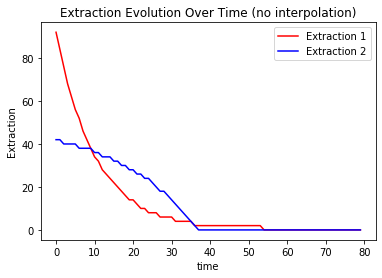

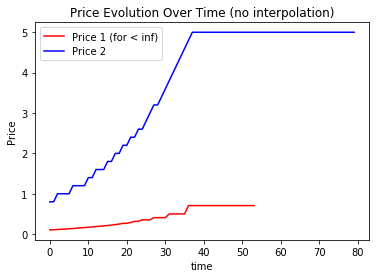

In [9]:
plt.plot(range(0,80), C1_v1, color="red", label="Extraction 1")
plt.plot(range(0,80), C2_v1, color="blue", label="Extraction 2")
plt.title("Extraction Evolution Over Time (no interpolation)")
plt.xlabel("time")
plt.ylabel("Extraction")
plt.legend()
plt.show()


# For printing purposes
plt.plot(range(0,80), p1_v1, color="red", label="Price 1 (for < inf)")
plt.plot(range(0,80), p2_v1, color="blue", label="Price 2")
plt.title("Price Evolution Over Time (no interpolation)")
plt.xlabel("time")
plt.ylabel("Price")
plt.legend()
plt.show()

## Question 2: Interpolating Between the States

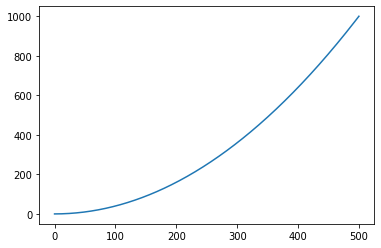

In [10]:
N2 = 501
Na2 = 501
S2 = np.linspace(0,1000,N2)
A2 = np.linspace(0,(1000**0.5),Na2)**2
plt.plot(range(501), A2)

In [11]:
### Compute utility matrix for utility 1 and 2 
utilitymatrix1_v2 = np.ones((N2, Na2))
for i in range(0,N2):
    for j in range(0,Na2):
        utilitymatrix1_v2[i,j] = u_f1(S2[i], A2[j])
        
utilitymatrix2_v2 = np.ones((N2, Na2))
for i in range(0,N2):
    for j in range(0,Na2):
        utilitymatrix2_v2[i,j] = u_f2(S2[i], A2[j])


In [12]:
### Compute the Transition Matrix
T2 = T_f(S2, A2, interp=True)
T2 = csr_matrix(T2)

In [13]:
### VFI 
V0 = np.zeros(N2)
[Vp1_v2, IndexAction1_v2, iter1_v2] = VFI_v2(S2, A2, V0, utilitymatrix1_v2, T = T2, print_i=True)
print("Utility 1: DONE")

[Vp2_v2, IndexAction2_v2, iter2_v2] = VFI_v2(S2, A2, V0, utilitymatrix2_v2, T = T2, print_i=False)
print("Utility 2: DONE")




iteration is  0  and Error term is  999.6306757998175
iteration is  1  and Error term is  382.22358359005364
iteration is  2  and Error term is  271.571086320296
iteration is  3  and Error term is  212.4579473176012
iteration is  4  and Error term is  173.61935439472015
iteration is  5  and Error term is  145.52413508394983
iteration is  6  and Error term is  124.15091213179542
iteration is  7  and Error term is  107.05369166338109
iteration is  8  and Error term is  93.12997699892438
iteration is  9  and Error term is  81.61902093185495
iteration is  10  and Error term is  71.86880582805578
iteration is  11  and Error term is  63.499016900233514
iteration is  12  and Error term is  56.34387846166145
iteration is  13  and Error term is  50.11094282974448
iteration is  14  and Error term is  44.7271788902159
iteration is  15  and Error term is  40.03579837182327
iteration is  16  and Error term is  35.830256185787505
iteration is  17  and Error term is  32.08515277453874
iteration is  1

iteration is  144  and Error term is  9.264112207212626e-05
iteration is  145  and Error term is  8.384435652972197e-05
iteration is  146  and Error term is  7.587944973110667e-05
iteration is  147  and Error term is  6.866851015985712e-05
iteration is  148  and Error term is  6.214076891246526e-05
iteration is  149  and Error term is  5.623196484022768e-05
iteration is  150  and Error term is  5.0883776362478124e-05
iteration is  151  and Error term is  4.604329509733521e-05
iteration is  152  and Error term is  4.166254236062395e-05
iteration is  153  and Error term is  3.7698023761286684e-05
iteration is  154  and Error term is  3.4110321235545106e-05
iteration is  155  and Error term is  3.086372000750748e-05
iteration is  156  and Error term is  2.792586752857811e-05
iteration is  157  and Error term is  2.5267461755080753e-05
iteration is  158  and Error term is  2.2861967968253335e-05
iteration is  159  and Error term is  2.068536049624401e-05
iteration is  160  and Error term i

In [14]:
### Find the optimal Transition matrices
T_opt1_v2 = np.zeros((N2, N2))
for ik in range(N2):
    diff = S2[ik] - A2[int(IndexAction1_v2[ik])]
    dist = abs(S2 - diff) # How far from the differenre is each element of S2
    index1 = np.where(dist == sorted(dist)[0])[0][0] # Find the index of the closest
    index2 = np.where(dist == sorted(dist)[1])[0][0] # Find the index of the second closest
    weight1 = sorted(dist)[0] / np.sum(sorted(dist)[0:2])
    weight2 = sorted(dist)[1] / np.sum(sorted(dist)[0:2])
    weight1 + weight2 == 1 
    T_opt1_v2[ik, index1] = weight1
    T_opt1_v2[ik, index2] = weight2 
    
T_opt1_v2 = csr_matrix(T_opt1_v2)
    
T_opt2_v2 = np.zeros((N2, N2))
for ik in range(N2):
    diff = S2[ik] - A2[int(IndexAction2_v2[ik])]
    dist = abs(S2 - diff) # How far from the differenre is each element of S2
    index1 = np.where(dist == sorted(dist)[0])[0][0] # Find the index of the closest
    index2 = np.where(dist == sorted(dist)[1])[0][0] # Find the index of the second closest
    weight1 = sorted(dist)[0] / np.sum(sorted(dist)[0:2])
    weight2 = sorted(dist)[1] / np.sum(sorted(dist)[0:2])
    weight1 + weight2 == 1 
    T_opt2_v2[ik, index1] = weight1
    T_opt2_v2[ik, index2] = weight2 
    
T_opt2_v2 = csr_matrix(T_opt2_v2)

In [15]:
### Simulate

St1_v2 = 1000*np.ones(80)
C1_v2 = np.zeros(80)
for i in range(80-1):
    #init_index1 = np.where(S2==St1_v2[i])[0][0]
    init = St1_v2[i]
    # Find closest states
    dist = abs(S2 - init)
    tokeep = sorted(dist)[0:2]
    index1 = np.where(dist == tokeep[0])[0][0]
    index2 = np.where(dist == tokeep[1])[0][0]  
    weight1 = 1 - tokeep[0] / np.sum(tokeep[0:2])
    weight2 = 1 - tokeep[1] / np.sum(tokeep[0:2])
    weight1 + weight2 == 1
    C1_v2[i] = A2[int(IndexAction1_v2[index1])]*weight1 + A2[int(IndexAction1_v2[index2])]*weight2
    St1_v2[i+1] = St1_v2[i] - C1_v2[i]
p1_v2 = p1_f(C1_v2)

# Simulate
St2_v2 = 1000*np.ones(80)
C2_v2 = np.zeros(80)
for i in range(80-1):
    #init_index1 = np.where(S2==St1_v2[i])[0][0]
    init = St2_v2[i]
    # Find closest states
    dist = abs(S2 - init)
    tokeep = sorted(dist)[0:2]
    index1 = np.where(dist == tokeep[0])[0][0]
    index2 = np.where(dist == tokeep[1])[0][0]  
    weight1 = 1 - tokeep[0] / np.sum(tokeep[0:2])
    weight2 = 1 - tokeep[1] / np.sum(tokeep[0:2])
    weight1 + weight2 == 1
    C2_v2[i] = A2[int(IndexAction2_v2[index1])]*weight1 + A2[int(IndexAction2_v2[index2])]*weight2
    St2_v2[i+1] = St2_v2[i] - C2_v2[i]
    
p2_v2 = p2_f(C2_v2)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


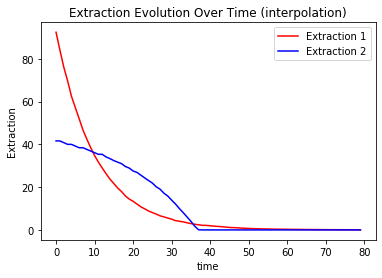

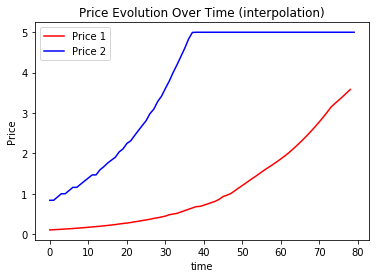

In [16]:
plt.plot(range(0,80), C1_v2, color="red", label="Extraction 1")
plt.plot(range(0,80), C2_v2, color="blue", label="Extraction 2")
plt.title("Extraction Evolution Over Time (interpolation)")
plt.xlabel("time")
plt.ylabel("Extraction")
plt.legend()
plt.show()


# For printing purposes
plt.plot(range(0,80), p1_v2, color="red", label="Price 1")
plt.plot(range(0,80), p2_v2, color="blue", label="Price 2")
plt.title("Price Evolution Over Time (interpolation)")
plt.xlabel("time")
plt.ylabel("Price")
plt.legend()
plt.show()

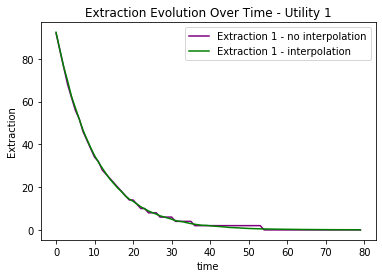

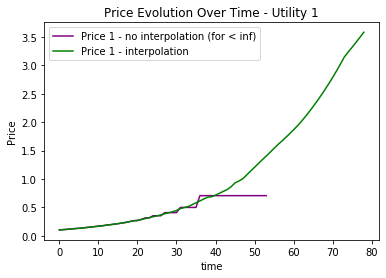

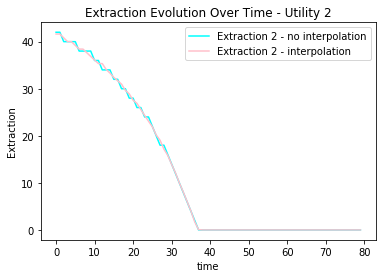

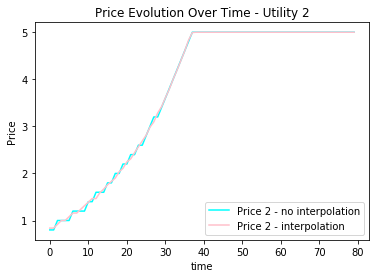

In [17]:
# For Free: a comparison of the interpolation & non-interpolation outcomes
plt.plot(range(0,80), C1_v1, color="purple", label="Extraction 1 - no interpolation")
plt.plot(range(0,80), C1_v2, color="green", label="Extraction 1 - interpolation")
plt.title("Extraction Evolution Over Time - Utility 1")
plt.xlabel("time")
plt.ylabel("Extraction")
plt.legend()
plt.show()

plt.plot(range(0,80), p1_v1, color="purple", label="Price 1 - no interpolation (for < inf)")
plt.plot(range(0,80), p1_v2, color="green", label="Price 1 - interpolation")
plt.title("Price Evolution Over Time - Utility 1")
plt.xlabel("time")
plt.ylabel("Price")
plt.legend()
plt.show()


plt.plot(range(0,80), C2_v1, color="cyan", label="Extraction 2 - no interpolation")
plt.plot(range(0,80), C2_v2, color="pink", label="Extraction 2 - interpolation")
plt.title("Extraction Evolution Over Time - Utility 2")
plt.xlabel("time")
plt.ylabel("Extraction")
plt.legend()
plt.show()

plt.plot(range(0,80), p2_v1, color="cyan", label="Price 2 - no interpolation")
plt.plot(range(0,80), p2_v2, color="pink", label="Price 2 - interpolation")
plt.title("Price Evolution Over Time - Utility 2")
plt.xlabel("time")
plt.ylabel("Price")
plt.legend()
plt.show()

A couple remarks about the differences between problem 1 and problem 2:
- Interestingly, with utility 1, notice that the price goes to $\infty$ in problem 1, but not in problem 2. The intuition is that with this utility, $u_1'(0)=\infty$, so if the agent is not constrained by the grid, he will make sure to always extract a strictly positive amount every period. When $t \to \infty$ we should converge to 0 stock, but always strictly positive. The grid interpolation approximates a continuous problem.
- For utility 2, we do not observe the same phenomenon because $u_2'$ is bounded about by 5.